2024 College football data from https://collegefootballdata.com

Let's see what we can do with it.

Data Dictionary:


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    classification_report,
    precision_recall_curve
)
from sklearn import metrics

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To impute missing values
from sklearn.impute import SimpleImputer

# To help with model building
from sklearn.linear_model import LogisticRegression

# To build classification models
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# For tuning the model
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras import backend
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
#pd.options.mode.copy_on_write = False

# To supress warnings
import warnings
warnings.filterwarnings("ignore")



In [ ]:
backend.clear_session()

from google.colab import drive
drive.mount('/content/drive')

win_loss = pd.read_csv('/content/drive/MyDrive/cfb/win_loss2.csv')
betting_lines = pd.read_csv('/content/drive/MyDrive/cfb/betting_lines2.csv')
post_lines = pd.read_csv('/content/drive/MyDrive/cfb/postseason_lines2.csv')
post = pd.read_csv('/content/drive/MyDrive/cfb/postseason2.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Check the data in win_loss
win_loss.head()

,Id,Season,Week,Season Type,Start Date,Start Time Tbd,Completed,Neutral Site,Conference Game,Attendance,...,Away Line Scores[0],Away Line Scores[1],Away Line Scores[2],Away Line Scores[3],Away Post Win Prob,Away Pregame Elo,Away Postgame Elo,Excitement Index,Highlights,Notes
0,401693677,2024,1,regular,2024-08-24T04:00:00.000Z,True,True,True,False,NaN,...,14.0,7.0,14.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
1,401635525,2024,1,regular,2024-08-24T16:00:00.000Z,False,True,True,True,NaN,...,8.0,6.0,0.0,7.0,0.008604,1692.0,1676.0,7.822224,NaN,Aer Lingus College Football Classic
2,401654665,2024,1,regular,2024-08-24T19:30:00.000Z,False,True,False,False,NaN,...,7.0,0.0,3.0,13.0,0.945634,NaN,NaN,5.564025,NaN,NaN
3,401643697,2024,1,regular,2024-08-24T20:00:00.000Z,False,True,False,False,NaN,...,0.0,14.0,0.0,21.0,0.698899,NaN,NaN,4.927318,NaN,NaN
4,401654662,2024,1,regular,2024-08-24T23:00:00.000Z,False,True,True,False,NaN,...,8.0,7.0,0.0,0.0,0.005052,NaN,NaN,7.171901,NaN,FCS Kickoff


In [ ]:
#  Data Types and Nulls
win_loss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 39 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   3798 non-null   int64  
 1   Season               3798 non-null   int64  
 2   Week                 3798 non-null   int64  
 3   Season Type          3798 non-null   object 
 4   Start Date           3798 non-null   object 
 5   Start Time Tbd       3798 non-null   bool   
 6   Completed            3798 non-null   bool   
 7   Neutral Site         3798 non-null   bool   
 8   Conference Game      3798 non-null   bool   
 9   Attendance           0 non-null      float64
 10  Venue Id             3789 non-null   float64
 11  Venue                3789 non-null   object 
 12  Home Id              3798 non-null   int64  
 13  Home Team            3798 non-null   object 
 14  Home Conference      3781 non-null   object 
 15  Home Division        3781 non-null   o

In [ ]:
post.head()

,Id,Season,Week,Season Type,Start Date,Start Time Tbd,Completed,Neutral Site,Conference Game,Attendance,...,Away Line Scores[0],Away Line Scores[1],Away Line Scores[2],Away Line Scores[3],Away Post Win Prob,Away Pregame Elo,Away Postgame Elo,Excitement Index,Highlights,Notes
0,401677076,2024,1,postseason,2024-12-14T17:00:00.000Z,False,True,True,False,NaN,...,0.0,14.0,0.0,14.0,0.999658,NaN,NaN,3.375234,NaN,Cricket Celebration Bowl
1,401677077,2024,1,postseason,2024-12-15T02:00:00.000Z,False,True,True,False,NaN,...,0.0,16.0,7.0,7.0,0.984988,1597.0,1583.0,4.424723,NaN,IS4S Salute to Veterans Bowl
2,401677080,2024,1,postseason,2024-12-18T02:00:00.000Z,False,True,True,False,NaN,...,7.0,21.0,7.0,7.0,0.668848,1666.0,1657.0,3.772187,NaN,Scooter's Coffee Frisco Bowl
3,401677079,2024,1,postseason,2024-12-18T22:30:00.000Z,False,True,True,False,NaN,...,0.0,14.0,0.0,3.0,0.015847,1363.0,1364.0,7.079454,NaN,Boca Raton Bowl
4,401677081,2024,1,postseason,2024-12-19T02:00:00.000Z,False,True,True,False,NaN,...,10.0,3.0,0.0,0.0,0.089623,1546.0,1529.0,7.105219,NaN,Art of Sport LA Bowl


In [ ]:
# Summary stats
win_loss.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,3798.0,4.016616e+08,22429.199886,4.016283e+08,4.016387e+08,4.016743e+08,4.016758e+08,4.017412e+08
Season,3798.0,2.024000e+03,0.000000,2.024000e+03,2.024000e+03,2.024000e+03,2.024000e+03,2.024000e+03
Week,3798.0,7.138231e+00,3.785757,1.000000e+00,4.000000e+00,7.000000e+00,1.000000e+01,1.600000e+01
Attendance,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Venue Id,3789.0,4.773945e+03,1321.673795,3.600000e+01,3.782000e+03,4.430000e+03,5.907000e+03,1.080300e+04
Home Id,3798.0,4.752075e+03,19090.074571,2.000000e+00,2.382500e+02,2.141000e+03,2.583000e+03,1.297380e+05
Home Points,3777.0,2.866720e+01,15.855033,0.000000e+00,1.700000e+01,2.800000e+01,3.800000e+01,9.600000e+01
Home Line Scores[0],3726.0,6.475845e+00,6.454743,0.000000e+00,0.000000e+00,7.000000e+00,1.000000e+01,4.200000e+01
Home Line Scores[1],3726.0,8.984165e+00,7.287353,0.000000e+00,3.000000e+00,7.000000e+00,1.400000e+01,4.200000e+01
Home Line Scores[2],3725.0,6.275436e+00,6.015943,0.000000e+00,0.000000e+00,7.000000e+00,1.000000e+01,3.500000e+01


In [ ]:
# What's the shape?
win_loss.shape

(3798, 39)

In [ ]:
# make a backup and drop unneeded columns
win_loss_backup = win_loss.copy()
#win_loss = win_loss_backup.copy()
# Determined I'm not going to use these columns
# Check if the columns exist before dropping them
columns_to_drop = ['Season', 'Season Type', 'Venue', 'Start Time Tbd', 'Attendance', 'Venue Id', 'Highlights', 'Notes','Home Line Scores[0]','Home Line Scores[1]','Home Line Scores[2]','Home Line Scores[3]','Away Line Scores[0]','Away Line Scores[1]','Away Line Scores[2]','Away Line Scores[3]']
 #  I need to drop completed, but I need to drop those rows first.
for column in columns_to_drop:
    if column in win_loss.columns:
        win_loss.drop(columns=[column], inplace=True)
    else:
        print(f"Column '{column}' not found in DataFrame. Skipping.")



In [ ]:
# What does it look like now?
win_loss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  3798 non-null   int64  
 1   Week                3798 non-null   int64  
 2   Start Date          3798 non-null   object 
 3   Completed           3798 non-null   bool   
 4   Neutral Site        3798 non-null   bool   
 5   Conference Game     3798 non-null   bool   
 6   Home Id             3798 non-null   int64  
 7   Home Team           3798 non-null   object 
 8   Home Conference     3781 non-null   object 
 9   Home Division       3781 non-null   object 
 10  Home Points         3777 non-null   float64
 11  Home Post Win Prob  1587 non-null   float64
 12  Home Pregame Elo    917 non-null    float64
 13  Home Postgame Elo   903 non-null    float64
 14  Away Id             3798 non-null   int64  
 15  Away Team           3798 non-null   object 
 16  Away C

In [ ]:
# Do the same with the prediction data.
# make a backup and drop unneeded columns
post_backup = post.copy()

# Determined I'm not going to use these columns
# Check if the columns exist before dropping them
columns_to_drop = ['Season', 'Season Type', 'Venue', 'Start Time Tbd', 'Attendance', 'Venue Id', 'Highlights', 'Notes','Home Line Scores[0]','Home Line Scores[1]','Home Line Scores[2]','Home Line Scores[3]','Away Line Scores[0]','Away Line Scores[1]','Away Line Scores[2]','Away Line Scores[3]']
 #  I need to drop completed, but I need to drop those rows first.
for column in columns_to_drop:
    if column in post.columns:
        post.drop(columns=[column], inplace=True)
    else:
        print(f"Column '{column}' not found in DataFrame. Skipping.")



In [ ]:
# Let's take a look at post


post.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  51 non-null     int64  
 1   Week                51 non-null     int64  
 2   Start Date          51 non-null     object 
 3   Completed           51 non-null     bool   
 4   Neutral Site        51 non-null     bool   
 5   Conference Game     51 non-null     bool   
 6   Home Id             51 non-null     int64  
 7   Home Team           51 non-null     object 
 8   Home Conference     51 non-null     object 
 9   Home Division       51 non-null     object 
 10  Home Points         33 non-null     float64
 11  Home Post Win Prob  31 non-null     float64
 12  Home Pregame Elo    43 non-null     float64
 13  Home Postgame Elo   30 non-null     float64
 14  Away Id             51 non-null     int64  
 15  Away Team           51 non-null     object 
 16  Away Confe

In [ ]:
#  Dropping all Division ii and iii win_loss.  I don't think they will be accurate for fbs and fcs
values_to_remove = ['ii', 'iii']
win_loss = win_loss[~win_loss['Home Division'].isin(values_to_remove)]
win_loss = win_loss[~win_loss['Away Division'].isin(values_to_remove)]


In [ ]:
# count the unique values of Home Division
win_loss['Home Division'].value_counts()

,count
Home Division,
fbs,917
fcs,708


In [ ]:
win_loss['Away Division'].value_counts()

,count
Away Division,
fcs,813
fbs,796


In [ ]:
#  Drop the win_loss that are not completed then drop the column
win_loss = win_loss[win_loss['Completed'] == True]
win_loss = win_loss.drop(columns=['Completed'])

post = post[post['Completed'] == False]
post = post.drop(columns=['Completed'])

In [ ]:
win_loss.head()

,Id,Week,Start Date,Neutral Site,Conference Game,Home Id,Home Team,Home Conference,Home Division,Home Points,...,Home Postgame Elo,Away Id,Away Team,Away Conference,Away Division,Away Points,Away Post Win Prob,Away Pregame Elo,Away Postgame Elo,Excitement Index
1,401635525,1,2024-08-24T16:00:00.000Z,True,True,59,Georgia Tech,ACC,fbs,24.0,...,1513.0,52,Florida State,ACC,fbs,21.0,0.008604,1692.0,1676.0,7.822224
2,401654665,1,2024-08-24T19:30:00.000Z,False,False,2627,Tarleton State,UAC,fcs,26.0,...,NaN,2377,McNeese,Southland,fcs,23.0,0.945634,NaN,NaN,5.564025
3,401643697,1,2024-08-24T20:00:00.000Z,False,False,167,New Mexico,Mountain West,fbs,31.0,...,1234.0,147,Montana State,Big Sky,fcs,35.0,0.698899,NaN,NaN,4.927318
4,401654662,1,2024-08-24T23:00:00.000Z,True,False,2546,Southeast Missouri State,Big South-OVC,fcs,37.0,...,NaN,2453,North Alabama,UAC,fcs,15.0,0.005052,NaN,NaN,7.171901
5,401636372,1,2024-08-24T23:30:00.000Z,True,False,2450,Norfolk State,MEAC,fcs,23.0,...,NaN,50,Florida A&M,SWAC,fcs,24.0,0.081638,NaN,NaN,4.690313


In [ ]:
win_loss.shape

(1614, 22)

I want to add a betting line to the game.  So I need to evaluate betting_lines.

In [ ]:
# Get info
betting_lines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3161 entries, 0 to 3160
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                3161 non-null   int64  
 1   HomeTeam          3161 non-null   object 
 2   HomeScore         3122 non-null   float64
 3   AwayTeam          3161 non-null   object 
 4   AwayScore         3122 non-null   float64
 5   LineProvider      3161 non-null   object 
 6   OverUnder         3150 non-null   float64
 7   Spread            3152 non-null   float64
 8   FormattedSpread   3161 non-null   object 
 9   OpeningSpread     2327 non-null   float64
 10  OpeningOverUnder  1764 non-null   float64
 11  HomeMoneyline     2330 non-null   float64
 12  AwayMoneyline     2338 non-null   float64
dtypes: float64(8), int64(1), object(4)
memory usage: 321.2+ KB


In [ ]:
betting_lines.head()

,Id,HomeTeam,HomeScore,AwayTeam,AwayScore,LineProvider,OverUnder,Spread,FormattedSpread,OpeningSpread,OpeningOverUnder,HomeMoneyline,AwayMoneyline
0,401644735,Central Michigan,37.0,Ball State,34.0,Bovada,51.0,-6.5,Central Michigan -6.5,-6.5,53.0,-245.0,205.0
1,401644735,Central Michigan,37.0,Ball State,34.0,ESPN Bet,49.5,-5.5,Central Michigan -5.5,-6.5,52.5,-230.0,195.0
2,401644735,Central Michigan,37.0,Ball State,34.0,DraftKings,50.5,-6.5,Central Michigan -6.5,NaN,NaN,-218.0,180.0
3,401655634,Lindenwood,64.0,St. Thomas (MN),0.0,ESPN Bet,47.5,-4.5,Lindenwood -4.5,NaN,NaN,NaN,NaN
4,401628632,Elon,17.0,Richmond,27.0,ESPN Bet,46.5,0.0,Richmond -0,NaN,NaN,NaN,NaN


In [ ]:
# Make a copy
#betting_lines = betting_lines_backup.copy()
betting_lines_backup = betting_lines.copy()
# betting_lines = betting_lines_backup.copy()
# Let's look at each LineProvider to see who has the most info
betting_lines['LineProvider'].value_counts()

,count
LineProvider,
ESPN Bet,1547
DraftKings,814
Bovada,800


In [ ]:
# I'm going to use espn bet
betting_lines_bovada = betting_lines[(betting_lines['LineProvider'] == 'Bovada') & betting_lines['OverUnder'].notnull()]
betting_lines_draftkings = betting_lines[(betting_lines['LineProvider'] == 'DraftKings') & betting_lines['OverUnder'].notnull()]
betting_lines_espn = betting_lines[(betting_lines['LineProvider'] == 'ESPN Bet') & betting_lines['OverUnder'].notnull()]


# prediction data
post_lines_bovada = post_lines[(post_lines['LineProvider'] == 'Bovada') & post_lines['OverUnder'].notnull()]
post_lines_draftkings = post_lines[(post_lines['LineProvider'] == 'DraftKings') & post_lines['OverUnder'].notnull()]
post_lines_espn = post_lines[(post_lines['LineProvider'] == 'ESPN Bet') & post_lines['OverUnder'].notnull()]


In [ ]:
post_lines_espn.head()

,Id,HomeTeam,HomeScore,AwayTeam,AwayScore,LineProvider,OverUnder,Spread,FormattedSpread,OpeningSpread,OpeningOverUnder,HomeMoneyline,AwayMoneyline
0,401677183,Oregon,NaN,Ohio State,NaN,ESPN Bet,55.5,2.5,Ohio State -2.5,2.0,53.5,110.0,-130.0
4,401677182,Arizona State,NaN,Texas,NaN,ESPN Bet,51.5,13.0,Texas -13,13.5,51.5,360.0,-500.0
8,401677181,Boise State,NaN,Penn State,NaN,ESPN Bet,53.5,11.0,Penn State -11,10.5,53.5,340.0,-450.0
11,401677184,Georgia,NaN,Notre Dame,NaN,ESPN Bet,44.5,-1.0,Georgia -1,-1.5,44.5,-120.0,105.0
12,401729787,Montana State,31.0,South Dakota,17.0,ESPN Bet,56.5,-9.5,Montana State -9.5,NaN,NaN,NaN,NaN


In [ ]:
# Prepare to merge - I'm going to start with DraftKings, then Bovada, then ESPN Bet
win_loss = pd.merge(win_loss, betting_lines_draftkings[['Id','Spread']], on='Id', how='left' )
win_loss = pd.merge(win_loss, betting_lines_draftkings[['Id','OverUnder']], on='Id', how='left')

merged_df = pd.merge(win_loss, betting_lines_bovada[['Id', 'Spread']], on='Id', how='left', suffixes=('', '_bovada'))
# Update 'Spread' and 'OverUnder' using a loop to check for index existence
for index in merged_df.index:
    if index in win_loss.index:
        win_loss.loc[index, 'Spread'] = merged_df.loc[index, 'Spread_bovada'] if pd.isnull(win_loss.loc[index, 'Spread']) else win_loss.loc[index, 'Spread']
        # Update 'Spread' with 'Spread_bovada' if 'Spread' is NaN, otherwise keep the original value

merged_df = pd.merge(win_loss, betting_lines_bovada[['Id', 'OverUnder']], on='Id', how='left', suffixes=('', '_bovada'))
# Update 'Spread' and 'OverUnder' using a loop to check for index existence
for index in merged_df.index:
    if index in win_loss.index:
        win_loss.loc[index, 'OverUnder'] = merged_df.loc[index, 'OverUnder_bovada'] if pd.isnull(win_loss.loc[index, 'OverUnder']) else win_loss.loc[index, 'OverUnder']
        # Update 'Spread' with 'Spread_bovada' if 'Spread' is NaN, otherwise keep the original value

merged_df = pd.merge(win_loss, betting_lines_espn[['Id', 'Spread']], on='Id', how='left', suffixes=('', '_espn'))
# Update 'Spread' and 'OverUnder' using a loop to check for index existence
for index in merged_df.index:
    if index in win_loss.index:
        win_loss.loc[index, 'Spread'] = merged_df.loc[index, 'Spread_espn'] if pd.isnull(win_loss.loc[index, 'Spread']) else win_loss.loc[index, 'Spread']
        # Update 'Spread' with 'Spread_bovada' if 'Spread' is NaN, otherwise keep the original value

merged_df = pd.merge(win_loss, betting_lines_espn[['Id', 'OverUnder']], on='Id', how='left', suffixes=('', '_espn'))
# Update 'Spread' and 'OverUnder' using a loop to check for index existence
for index in merged_df.index:
    if index in win_loss.index:
        win_loss.loc[index, 'OverUnder'] = merged_df.loc[index, 'OverUnder_espn'] if pd.isnull(win_loss.loc[index, 'OverUnder']) else win_loss.loc[index, 'OverUnder']
        # Update 'Spread' with 'Spread_bovada' if 'Spread' is NaN, otherwise keep the original value


In [ ]:
# Prepare to merge - I'm going to start with DraftKings, then Bovada, then ESPN Bet
# Prediction data
post = pd.merge(post, post_lines_draftkings[['Id','Spread']], on='Id', how='left' )
post = pd.merge(post, post_lines_draftkings[['Id','OverUnder']], on='Id', how='left')

merged_df = pd.merge(post, post_lines_bovada[['Id', 'Spread']], on='Id', how='left', suffixes=('', '_bovada'))
# Update 'Spread' and 'OverUnder' using a loop to check for index existence
for index in merged_df.index:
    if index in post.index:
        post.loc[index, 'Spread'] = merged_df.loc[index, 'Spread_bovada'] if pd.isnull(post.loc[index, 'Spread']) else post.loc[index, 'Spread']
        # Update 'Spread' with 'Spread_bovada' if 'Spread' is NaN, otherwise keep the original value

merged_df = pd.merge(post, post_lines_bovada[['Id', 'OverUnder']], on='Id', how='left', suffixes=('', '_bovada'))
# Update 'Spread' and 'OverUnder' using a loop to check for index existence
for index in merged_df.index:
    if index in post.index:
        post.loc[index, 'OverUnder'] = merged_df.loc[index, 'OverUnder_bovada'] if pd.isnull(post.loc[index, 'OverUnder']) else post.loc[index, 'OverUnder']
        # Update 'Spread' with 'Spread_bovada' if 'Spread' is NaN, otherwise keep the original value

merged_df = pd.merge(post, post_lines_espn[['Id', 'Spread']], on='Id', how='left', suffixes=('', '_espn'))
# Update 'Spread' and 'OverUnder' using a loop to check for index existence
for index in merged_df.index:
    if index in post.index:
        post.loc[index, 'Spread'] = merged_df.loc[index, 'Spread_espn'] if pd.isnull(post.loc[index, 'Spread']) else post.loc[index, 'Spread']
        # Update 'Spread' with 'Spread_bovada' if 'Spread' is NaN, otherwise keep the original value

merged_df = pd.merge(post, post_lines_espn[['Id', 'OverUnder']], on='Id', how='left', suffixes=('', '_espn'))
# Update 'Spread' and 'OverUnder' using a loop to check for index existence
for index in merged_df.index:
    if index in post.index:
        post.loc[index, 'OverUnder'] = merged_df.loc[index, 'OverUnder_espn'] if pd.isnull(post.loc[index, 'OverUnder']) else post.loc[index, 'OverUnder']
        # Update 'Spread' with 'Spread_bovada' if 'Spread' is NaN, otherwise keep the original value


In [ ]:

#betting_lines.head()
win_loss.head()
#merged_df.head()


,Id,Week,Start Date,Neutral Site,Conference Game,Home Id,Home Team,Home Conference,Home Division,Home Points,...,Away Team,Away Conference,Away Division,Away Points,Away Post Win Prob,Away Pregame Elo,Away Postgame Elo,Excitement Index,Spread,OverUnder
0,401635525,1,2024-08-24T16:00:00.000Z,True,True,59,Georgia Tech,ACC,fbs,24.0,...,Florida State,ACC,fbs,21.0,0.008604,1692.0,1676.0,7.822224,11.5,55.5
1,401654665,1,2024-08-24T19:30:00.000Z,False,False,2627,Tarleton State,UAC,fcs,26.0,...,McNeese,Southland,fcs,23.0,0.945634,NaN,NaN,5.564025,-15.5,63.5
2,401643697,1,2024-08-24T20:00:00.000Z,False,False,167,New Mexico,Mountain West,fbs,31.0,...,Montana State,Big Sky,fcs,35.0,0.698899,NaN,NaN,4.927318,10.5,54.0
3,401654662,1,2024-08-24T23:00:00.000Z,True,False,2546,Southeast Missouri State,Big South-OVC,fcs,37.0,...,North Alabama,UAC,fcs,15.0,0.005052,NaN,NaN,7.171901,-7.5,58.5
4,401636372,1,2024-08-24T23:30:00.000Z,True,False,2450,Norfolk State,MEAC,fcs,23.0,...,Florida A&M,SWAC,fcs,24.0,0.081638,NaN,NaN,4.690313,13.5,50.5


In [ ]:
win_loss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1614 entries, 0 to 1613
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  1614 non-null   int64  
 1   Week                1614 non-null   int64  
 2   Start Date          1614 non-null   object 
 3   Neutral Site        1614 non-null   bool   
 4   Conference Game     1614 non-null   bool   
 5   Home Id             1614 non-null   int64  
 6   Home Team           1614 non-null   object 
 7   Home Conference     1609 non-null   object 
 8   Home Division       1609 non-null   object 
 9   Home Points         1614 non-null   float64
 10  Home Post Win Prob  1557 non-null   float64
 11  Home Pregame Elo    903 non-null    float64
 12  Home Postgame Elo   903 non-null    float64
 13  Away Id             1614 non-null   int64  
 14  Away Team           1614 non-null   object 
 15  Away Conference     1593 non-null   object 
 16  Away D

In [ ]:
#  Any dups?
win_loss.duplicated().sum()

0

In [ ]:
#drop other columns we don't need

columns_to_drop = ['Id', 'Home Id', 'Away Id']

for column in columns_to_drop:
    if column in win_loss.columns:
        win_loss.drop(columns=[column], inplace=True)
    else:
        print(f"Column '{column}' not found in DataFrame. Skipping.")


In [ ]:
# Do the same for post
columns_to_drop = ['Id', 'Home Id', 'Away Id']

for column in columns_to_drop:
    if column in post.columns:
        post.drop(columns=[column], inplace=True)
    else:
        print(f"Column '{column}' not found in DataFrame. Skipping.")



In [ ]:
win_loss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1614 entries, 0 to 1613
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Week                1614 non-null   int64  
 1   Start Date          1614 non-null   object 
 2   Neutral Site        1614 non-null   bool   
 3   Conference Game     1614 non-null   bool   
 4   Home Team           1614 non-null   object 
 5   Home Conference     1609 non-null   object 
 6   Home Division       1609 non-null   object 
 7   Home Points         1614 non-null   float64
 8   Home Post Win Prob  1557 non-null   float64
 9   Home Pregame Elo    903 non-null    float64
 10  Home Postgame Elo   903 non-null    float64
 11  Away Team           1614 non-null   object 
 12  Away Conference     1593 non-null   object 
 13  Away Division       1593 non-null   object 
 14  Away Points         1614 non-null   float64
 15  Away Post Win Prob  1557 non-null   float64
 16  Away P

In [ ]:
# More data cleanup
pd.set_option("display.max_columns", 30)
print(win_loss[win_loss['Home Conference'].isnull()])


     Week                Start Date  Neutral Site  Conference Game  \
151     2  2024-09-07T17:00:00.000Z          True            False   
311     3  2024-09-14T22:00:00.000Z          True            False   
386     4  2024-09-21T17:00:00.000Z         False            False   
498     5  2024-09-28T17:00:00.000Z         False            False   
735     7  2024-10-12T18:00:00.000Z          True            False   

                       Home Team Home Conference Home Division  Home Points  \
151           Concordia-Michigan             NaN           NaN         34.0   
311  University Of St Francis IN             NaN           NaN         64.0   
386             Defiance College             NaN           NaN         38.0   
498             Defiance College             NaN           NaN          7.0   
735                St. Xavier IL             NaN           NaN         45.0   

     Home Post Win Prob  Home Pregame Elo  Home Postgame Elo  \
151                 NaN               Na

In [ ]:
#  I'm dropping the win_loss without a Conference
win_loss = win_loss[~win_loss['Home Conference'].isnull()]
win_loss = win_loss[~win_loss['Away Conference'].isnull()]
win_loss.shape

(1593, 21)

In [ ]:
win_loss.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1593 entries, 0 to 1613
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Week                1593 non-null   int64  
 1   Start Date          1593 non-null   object 
 2   Neutral Site        1593 non-null   bool   
 3   Conference Game     1593 non-null   bool   
 4   Home Team           1593 non-null   object 
 5   Home Conference     1593 non-null   object 
 6   Home Division       1593 non-null   object 
 7   Home Points         1593 non-null   float64
 8   Home Post Win Prob  1544 non-null   float64
 9   Home Pregame Elo    903 non-null    float64
 10  Home Postgame Elo   903 non-null    float64
 11  Away Team           1593 non-null   object 
 12  Away Conference     1593 non-null   object 
 13  Away Division       1593 non-null   object 
 14  Away Points         1593 non-null   float64
 15  Away Post Win Prob  1544 non-null   float64
 16  Away Pregam

In [ ]:
#I'm going to add a winner column and then look at rows with null values

# Create 'Home_Win' column
win_loss['Home_Win'] = (win_loss['Home Points'] > win_loss['Away Points']).astype(int)



In [ ]:
#fcs does not have Elo rantings.  Let's create a function is give me them one.

# I'm going to put it in a new data frame so I don't screw up my current

def get_expected_score(rating, opp_rating):
    exp = (opp_rating - rating) / 400
    return 1 / (1 + 10**exp)

def get_new_elos(home_rating, away_rating, margin):
    k = 25

    # score of 0.5 for a tie
    home_score = 0.5
    if margin > 0:
        # score of 1 for a win
        home_score = 1
    elif margin < 0:
        #score of 0 for a loss
        home_score = 0

    # get expected home score
    expected_home_score = get_expected_score(home_rating, away_rating)
    # multiply difference of actual and expected score by k value and adjust home rating
    new_home_score = home_rating + k * (home_score - expected_home_score)

    # repeat these steps for the away team
    # away score is inverse of home score
    away_score = 1 - home_score
    expected_away_score = get_expected_score(away_rating, home_rating)
    new_away_score = away_rating + k * (away_score - expected_away_score)

    # return a tuple
    return (round(new_home_score), round(new_away_score), expected_home_score, expected_away_score)

#def date_sort(game):
 #   game_date = datetime.datetime.strptime(game['start_date'], "%Y-%m-%dT%H:%M:%S.000Z")
 #   return game_date

#def elo_sort(team):
 #   return team['elo']


In [ ]:
#Sorting before the elo function

win_loss['Start Date'] = pd.to_datetime(win_loss['Start Date'])
win_loss = win_loss.sort_values(by=['Start Date'])
win_loss.head()

,Week,Start Date,Neutral Site,Conference Game,Home Team,Home Conference,Home Division,Home Points,Home Post Win Prob,Home Pregame Elo,Home Postgame Elo,Away Team,Away Conference,Away Division,Away Points,Away Post Win Prob,Away Pregame Elo,Away Postgame Elo,Excitement Index,Spread,OverUnder,Home_Win
0,1,2024-08-24 16:00:00+00:00,True,True,Georgia Tech,ACC,fbs,24.0,0.991396,1497.0,1513.0,Florida State,ACC,fbs,21.0,0.008604,1692.0,1676.0,7.822224,11.5,55.5,1
1,1,2024-08-24 19:30:00+00:00,False,False,Tarleton State,UAC,fcs,26.0,0.054366,NaN,NaN,McNeese,Southland,fcs,23.0,0.945634,NaN,NaN,5.564025,-15.5,63.5,1
2,1,2024-08-24 20:00:00+00:00,False,False,New Mexico,Mountain West,fbs,31.0,0.301101,1234.0,1234.0,Montana State,Big Sky,fcs,35.0,0.698899,NaN,NaN,4.927318,10.5,54.0,0
3,1,2024-08-24 23:00:00+00:00,True,False,Southeast Missouri State,Big South-OVC,fcs,37.0,0.994948,NaN,NaN,North Alabama,UAC,fcs,15.0,0.005052,NaN,NaN,7.171901,-7.5,58.5,1
4,1,2024-08-24 23:30:00+00:00,True,False,Norfolk State,MEAC,fcs,23.0,0.918362,NaN,NaN,Florida A&M,SWAC,fcs,24.0,0.081638,NaN,NaN,4.690313,13.5,50.5,0


In [ ]:
# dict object to hold current Elo rating for each team
teams = {}  # Changed to dictionary

# loop through win_loss in order
for index, game in win_loss.iterrows(): # Use iterrows() to iterate through DataFrame

    # get current rating for home team
    if game['Home Team'] in teams:
        home_elo = teams[game['Home Team']]
    elif game['Home Division'] == 'fbs' and game['Home Pregame Elo'] is not None:
        # if no rating, set initial rating to 1500 for FBS teams
        home_elo = 1500
    else:
        # otherwise, set initial rating to 1200 for non-FBS teams
        home_elo = 1300

    # get current rating for away team
    if game['Away Team'] in teams:
        away_elo = teams[game['Away Team']]
    elif game['Away Division'] == 'fbs' and game['Away Pregame Elo'] is not None:
        # if no rating, set initial rating to 1500 for FBS teams
        away_elo = 1500
    else:
        # otherwise, set initial rating to 1200 for non-FBS teams
        away_elo = 1300

    # calculate score margin from game
    margin = game['Home Points'] - game['Away Points'] # Changed column names

    # get new elo ratings
    new_elos = get_new_elos(home_elo, away_elo, margin)

    # set pregame elos on game
    win_loss.loc[index, 'Home Pregame Elo'] = home_elo # Use .loc to update DataFrame
    win_loss.loc[index, 'Away Pregame Elo'] = away_elo # Use .loc to update DataFrame

    # set postgame elos on game
    win_loss.loc[index, 'Home Postgame Elo'] = new_elos[0] # Use .loc to update DataFrame
    win_loss.loc[index, 'Away Postgame Elo'] = new_elos[1] # Use .loc to update DataFrame
    win_loss.loc[index, 'Home Post Win Prob'] = new_elos[2]
    win_loss.loc[index, 'Away Post Win Prob'] = new_elos[3]

    # set current elo values in teams dict
    teams[game['Home Team']] = new_elos[0]
    teams[game['Away Team']] = new_elos[1]


In [ ]:
# Set options to display all rows and columns
pd.set_option("display.max_rows", 20)  # Display all rows
pd.set_option("display.max_columns", None)  # Display all columns

#  I'll go ahead and change Home Division to binary fbs = 1 and fcs = 0
win_loss['Home Division'] = win_loss['Home Division'].apply(lambda x: 1 if x == 'fbs' else 0)
win_loss['Away Division'] = win_loss['Away Division'].apply(lambda x: 1 if x == 'fbs' else 0)
win_loss.head()

,Week,Start Date,Neutral Site,Conference Game,Home Team,Home Conference,Home Division,Home Points,Home Post Win Prob,Home Pregame Elo,Home Postgame Elo,Away Team,Away Conference,Away Division,Away Points,Away Post Win Prob,Away Pregame Elo,Away Postgame Elo,Excitement Index,Spread,OverUnder,Home_Win
0,1,2024-08-24 16:00:00+00:00,True,True,Georgia Tech,ACC,1,24.0,0.500000,1500.0,1512.0,Florida State,ACC,1,21.0,0.500000,1500.0,1488.0,7.822224,11.5,55.5,1
1,1,2024-08-24 19:30:00+00:00,False,False,Tarleton State,UAC,0,26.0,0.500000,1300.0,1312.0,McNeese,Southland,0,23.0,0.500000,1300.0,1288.0,5.564025,-15.5,63.5,1
2,1,2024-08-24 20:00:00+00:00,False,False,New Mexico,Mountain West,1,31.0,0.759747,1500.0,1481.0,Montana State,Big Sky,0,35.0,0.240253,1300.0,1319.0,4.927318,10.5,54.0,0
3,1,2024-08-24 23:00:00+00:00,True,False,Southeast Missouri State,Big South-OVC,0,37.0,0.500000,1300.0,1312.0,North Alabama,UAC,0,15.0,0.500000,1300.0,1288.0,7.171901,-7.5,58.5,1
4,1,2024-08-24 23:30:00+00:00,True,False,Norfolk State,MEAC,0,23.0,0.500000,1300.0,1288.0,Florida A&M,SWAC,0,24.0,0.500000,1300.0,1312.0,4.690313,13.5,50.5,0


In [ ]:
post['Home Division'] = post['Home Division'].apply(lambda x: 1 if x == 'fbs' else 0)
post['Away Division'] = post['Away Division'].apply(lambda x: 1 if x == 'fbs' else 0)


In [ ]:
#How many nulls do we have left?

null_counts = win_loss.isnull().sum()

print(null_counts)

Week                  0
Start Date            0
Neutral Site          0
Conference Game       0
Home Team             0
                     ..
Away Postgame Elo     0
Excitement Index     49
Spread               57
OverUnder            57
Home_Win              0
Length: 22, dtype: int64


In [ ]:
# Let's set the null excitement index to the mean
win_loss['Excitement Index'].fillna(win_loss['Excitement Index'].mean(), inplace=True)


In [ ]:
null_spreads = win_loss[win_loss['Spread'].isnull()]

# Print the null spreads
print(null_spreads)

      Week                Start Date  Neutral Site  Conference Game  \
9        1 2024-08-29 23:00:00+00:00         False            False   
35       1 2024-08-30 22:00:00+00:00         False            False   
42       1 2024-08-31 04:00:00+00:00         False            False   
44       1 2024-08-31 16:00:00+00:00         False            False   
76       1 2024-08-31 21:00:00+00:00         False            False   
...    ...                       ...           ...              ...   
1073    10 2024-11-02 18:00:00+00:00         False             True   
1072    10 2024-11-02 18:00:00+00:00         False             True   
1071    10 2024-11-02 18:00:00+00:00         False             True   
1339    12 2024-11-16 22:00:00+00:00         False             True   
1418    13 2024-11-23 19:00:00+00:00         False             True   

                Home Team    Home Conference  Home Division  Home Points  \
9             Wake Forest                ACC              1         45.

In [ ]:
# I hate to remove them, but they don't have a spread.

win_loss = win_loss.dropna(subset=['Spread'])

In [ ]:
null_counts = win_loss.isnull().sum()

print(null_counts)

Week                 0
Start Date           0
Neutral Site         0
Conference Game      0
Home Team            0
                    ..
Away Postgame Elo    0
Excitement Index     0
Spread               0
OverUnder            0
Home_Win             0
Length: 22, dtype: int64


In [ ]:
# Clean up post
post.head()

,Week,Start Date,Neutral Site,Conference Game,Home Team,Home Conference,Home Division,Home Points,Home Post Win Prob,Home Pregame Elo,Home Postgame Elo,Away Team,Away Conference,Away Division,Away Points,Away Post Win Prob,Away Pregame Elo,Away Postgame Elo,Excitement Index,Spread,OverUnder
0,1,2024-12-21T17:00:00.000Z,False,False,University of Mount Union,Ohio,0,NaN,NaN,NaN,NaN,Johns Hopkins University,Centennial,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2024-12-21T19:00:00.000Z,True,False,Valdosta State,Gulf South,0,NaN,NaN,NaN,NaN,Ferris State,GLIAC,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2024-12-21T20:30:00.000Z,False,False,North Central College,CCIW,0,NaN,NaN,NaN,NaN,Susquehanna,Landmark Conference,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2024-12-30T19:30:00.000Z,True,False,Missouri,SEC,1,NaN,NaN,1701.0,NaN,Iowa,Big Ten,1,NaN,NaN,1784.0,NaN,NaN,-1.0,41.0
4,1,2024-12-31T17:00:00.000Z,True,False,Michigan,Big Ten,1,NaN,NaN,1888.0,NaN,Alabama,SEC,1,NaN,NaN,2007.0,NaN,NaN,14.0,43.5


In [ ]:
# Sort the dataframe by 'Start Date' in descending order (most recent first)
win_loss = win_loss.sort_values(by=['Start Date'], ascending=False)

# Create an empty dictionary to store the Elo ratings
elo_dict = {}

# Iterate through the dataframe and update the dictionary
for index, row in win_loss.iterrows():
    elo_dict[row['Home Team']] = row['Home Postgame Elo']
    elo_dict[row['Away Team']] = row['Away Postgame Elo']

In [ ]:
post['Home Pregame Elo'] = post['Home Team'].map(elo_dict)
post['Away Pregame Elo'] = post['Away Team'].map(elo_dict)

In [ ]:
post.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Week                18 non-null     int64  
 1   Start Date          18 non-null     object 
 2   Neutral Site        18 non-null     bool   
 3   Conference Game     18 non-null     bool   
 4   Home Team           18 non-null     object 
 5   Home Conference     18 non-null     object 
 6   Home Division       18 non-null     int64  
 7   Home Points         0 non-null      float64
 8   Home Post Win Prob  0 non-null      float64
 9   Home Pregame Elo    14 non-null     float64
 10  Home Postgame Elo   0 non-null      float64
 11  Away Team           18 non-null     object 
 12  Away Conference     18 non-null     object 
 13  Away Division       18 non-null     int64  
 14  Away Points         0 non-null      float64
 15  Away Post Win Prob  0 non-null      float64
 16  Away Prega

In [ ]:
columns_to_drop = ['Home Points', 'Home Line Scores', 'Home Post Win Prob', 'Home Postgame Elo', 'Away Points', 'Away Line Scores', 'Away Post Win Prob', 'Away Postgame Elo']

for column in columns_to_drop:
    if column in post.columns:
        post.drop(columns=[column], inplace=True)

**Bivariant Analysis**

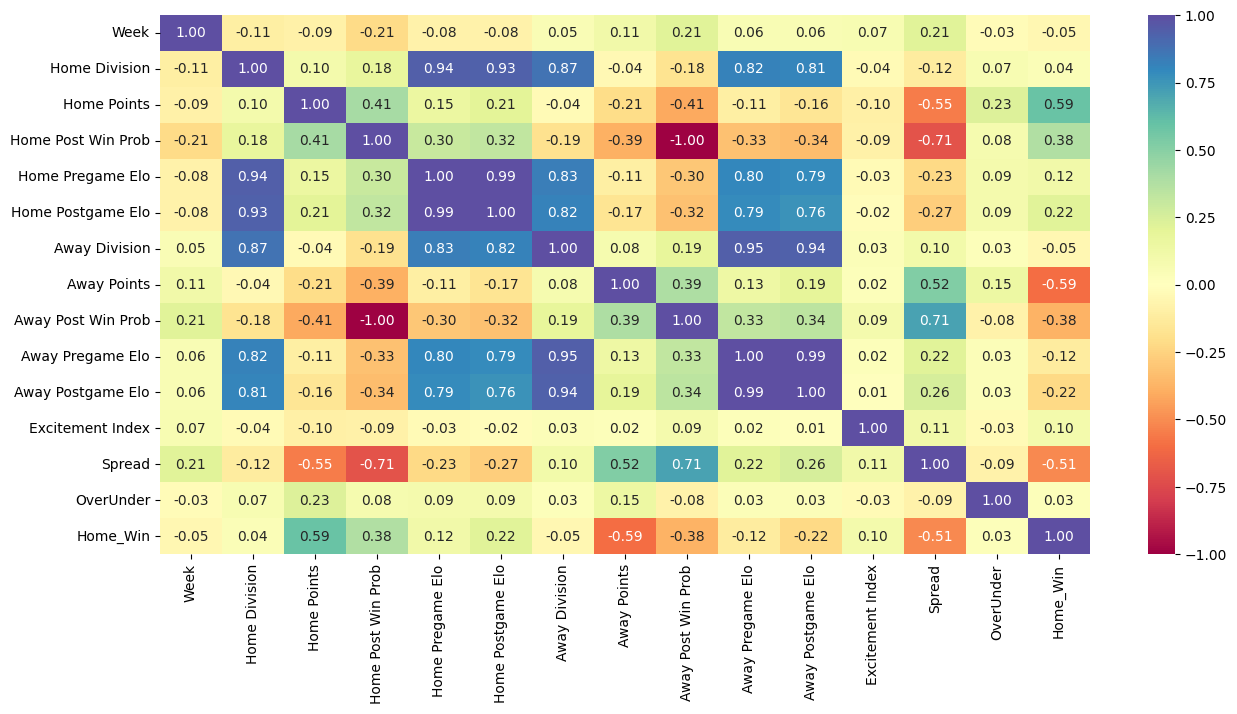

In [ ]:
numeric_data = win_loss.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(15, 7))
sns.heatmap(numeric_data.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

Conclusions:

1.  There is a correlation of -1 with df['Home Pregame Elo'] = df['Home Team'].map(elo_dict) Post Win Probablility and Away Post Win Probablily.  Makes sense as only 1 winner and loser.

2.  Strong Corellation with Home Division and Pregame Elo, Postgame Elo, and Away Divsion.  

3.  Looks like fbs vs fcs and elos make a different.

**We have our data now.  Time to create a model**

In [ ]:
win_loss.head()

,Week,Start Date,Neutral Site,Conference Game,Home Team,Home Conference,Home Division,Home Points,Home Post Win Prob,Home Pregame Elo,Home Postgame Elo,Away Team,Away Conference,Away Division,Away Points,Away Post Win Prob,Away Pregame Elo,Away Postgame Elo,Excitement Index,Spread,OverUnder,Home_Win
1613,1,2024-12-29 02:15:00+00:00,True,False,Army,American Athletic,1,27.0,0.655821,1583.0,1592.0,Louisiana Tech,Conference USA,1,6.0,0.344179,1471.0,1462.0,2.846036,-15.0,44.5,1
1612,1,2024-12-29 00:30:00+00:00,True,True,Colorado,Big 12,1,14.0,0.482737,1559.0,1547.0,BYU,Big 12,1,36.0,0.517263,1571.0,1583.0,2.365038,-3.0,55.5,0
1611,1,2024-12-28 22:45:00+00:00,True,False,NC State,ACC,1,21.0,0.468382,1495.0,1483.0,East Carolina,American Athletic,1,26.0,0.531618,1517.0,1529.0,7.197590,-7.5,61.5,0
1610,1,2024-12-28 21:30:00+00:00,True,False,Colorado State,Mountain West,1,17.0,0.492805,1534.0,1522.0,Miami (OH),Mid-American,1,43.0,0.507195,1539.0,1551.0,5.330897,1.0,42.5,0
1609,1,2024-12-28 20:30:00+00:00,True,False,Miami,ACC,1,41.0,0.514387,1573.0,1560.0,Iowa State,Big 12,1,42.0,0.485613,1563.0,1576.0,7.316554,-5.0,62.0,0


In [ ]:
# function for metrics
def metrics_score(actual, predicted):
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=class_names_list, yticklabels=class_names_list)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras



# Select features
features = ['Home Pregame Elo', 'Away Pregame Elo', 'Spread', 'OverUnder']
X = win_loss[features]
y = win_loss['Home_Win']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features (optional but recommended)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create model
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile model
#model.compile(optimizer='Adagrad', loss='binary_crossentropy', metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC()])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC()])
fit_history = model.fit(X_train, y_train,validation_split=0.1, verbose=1, epochs=10, batch_size=64)



Epoch 1/10
18/18 [==============================] - 1s 20ms/step - loss: 0.6273 - accuracy: 0.7204 - precision_1: 0.7774 - recall_1: 0.7625 - auc_1: 0.7775 - val_loss: 0.5654 - val_accuracy: 0.6992 - val_precision_1: 0.6923 - val_recall_1: 0.8750 - val_auc_1: 0.8272
Epoch 2/10
18/18 [==============================] - 0s 4ms/step - loss: 0.5230 - accuracy: 0.7457 - precision_1: 0.7701 - recall_1: 0.8348 - auc_1: 0.8182 - val_loss: 0.5166 - val_accuracy: 0.7154 - val_precision_1: 0.7079 - val_recall_1: 0.8750 - val_auc_1: 0.8313
Epoch 3/10
18/18 [==============================] - 0s 5ms/step - loss: 0.5021 - accuracy: 0.7475 - precision_1: 0.7871 - recall_1: 0.8068 - auc_1: 0.8208 - val_loss: 0.5175 - val_accuracy: 0.7317 - val_precision_1: 0.7241 - val_recall_1: 0.8750 - val_auc_1: 0.8305
Epoch 4/10
18/18 [==============================] - 0s 5ms/step - loss: 0.5017 - accuracy: 0.7376 - precision_1: 0.7725 - recall_1: 0.8112 - auc_1: 0.8206 - val_loss: 0.5067 - val_accuracy: 0.7317 - va

In [ ]:
new_data = post[features]
  # Replace with your actual new data

# 2. Scale the new data using the same scaler used for training
new_data_scaled = scaler.transform(new_data)

# 3. Make predictions using the trained model
predictions_prob = model.predict(new_data_scaled)  # Predicted probabilities
predictions = (predictions_prob > 0.5).astype(int)  # Predicted Home_Win (0 or 1)


1/1 [==============================] - 0s 83ms/step


In [ ]:
post['Predicted_Probability'] = predictions_prob.flatten() # Ensures the shape is correct
post['Predicted_Home_Win'] = predictions.flatten()


In [ ]:
post.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Week                   18 non-null     int64  
 1   Start Date             18 non-null     object 
 2   Neutral Site           18 non-null     bool   
 3   Conference Game        18 non-null     bool   
 4   Home Team              18 non-null     object 
 5   Home Conference        18 non-null     object 
 6   Home Division          18 non-null     int64  
 7   Home Pregame Elo       14 non-null     float64
 8   Away Team              18 non-null     object 
 9   Away Conference        18 non-null     object 
 10  Away Division          18 non-null     int64  
 11  Away Pregame Elo       14 non-null     float64
 12  Excitement Index       0 non-null      float64
 13  Spread                 13 non-null     float64
 14  OverUnder              13 non-null     float64
 15  Predicte

In [ ]:
ordered_columns = ['Home Team', 'Away Team', 'Predicted_Home_Win', 'Predicted_Probability']
#ordered_columns = ['Home Team', 'Away Team']
post_ordered = post[ordered_columns]
post_ordered['Predicted_Probability'] = post_ordered.apply(
    lambda row: 1 - row['Predicted_Probability'] if row['Predicted_Home_Win'] == 0 else row['Predicted_Probability'],
    axis=1
)

post_ordered['Predicted_Winner'] = post_ordered.apply(
    lambda row: row['Home Team'] if row['Predicted_Home_Win'] == 1 else row['Away Team'],
    axis=1
)


# Format Predicted_Probability with 4 decimal places
post_ordered['Predicted_Probability'] = post_ordered['Predicted_Probability'].map('{:.4f}'.format)
post_ordered = post_ordered.sort_values(by=['Predicted_Probability'], ascending=False)
# Print the formatted DataFrame
print(post_ordered.to_string())
# Use to_string() for better formatting in the output

                    Home Team                  Away Team  Predicted_Home_Win Predicted_Probability           Predicted_Winner
0   University of Mount Union   Johns Hopkins University                   0                   nan   Johns Hopkins University
1              Valdosta State               Ferris State                   0                   nan               Ferris State
16      North Central College  University of Mount Union                   0                   nan  University of Mount Union
17              Montana State         North Dakota State                   0                   nan         North Dakota State
2       North Central College                Susquehanna                   0                   nan                Susquehanna
12                   Ole Miss                       Duke                   1                0.8951                   Ole Miss
13                Texas State                North Texas                   1                0.8028                Texa